<a href="https://colab.research.google.com/github/lponcec94/PolyWorks/blob/main/semana_8/Semana_8_Survival_Anlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines
# !pip install plotly==4.14.3

### Objetivo

Implementar el análisis de supervivencia a datos sobre prestamos, para esto veremos:
  1. Estimador Kaplan Meier
  2. Modelo de Cox
  3. Cómo se distinguen

### Carga

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

pd.set_option('display.width', 5000)
# pd.options.plotting.backend = 'plotly'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [88]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/semana_8/prosperLoanData.csv')
df_dict = pd.read_csv('/content/drive/MyDrive/Kaggle/semana_8/Prosper Loan Data - Variable Definitions.csv')

In [89]:
df_dict.head()

,Variable,Description
0,ListingKey,"Unique key for each listing, same value as the..."
1,ListingNumber,The number that uniquely identifies the listin...
2,ListingCreationDate,The date the listing was created.
3,CreditGrade,The Credit rating that was assigned at the tim...
4,Term,The length of the loan expressed in months.


In [90]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,...,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,...,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,...,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN,Executive,Employed,44.0,

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

#### Filtrando columnas

In [164]:
df_sub = df.loc[:, [ 'LoanKey', 'ProsperRating (numeric)', 'EmploymentStatusDuration',
                    'LoanOriginationDate', 'LoanStatus', 'EmploymentStatus',
                    'ClosedDate', 'Occupation', 'BorrowerState', 'IsBorrowerHomeowner',
                    'StatedMonthlyIncome', 'IncomeRange', 'LoanOriginalAmount']]
df_sub.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12 00:00:00,Completed,Self-employed,2009-08-14 00:00:00,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03 00:00:00,Current,Employed,NaN,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17 00:00:00,Completed,Not available,2009-12-17 00:00:00,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01 00:00:00,Current,Employed,NaN,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20 00:00:00,Current,Employed,NaN,Executive,MN,True,9583.333333,"$100,000+",15000


In [165]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   LoanKey                   113937 non-null  object 
 1   ProsperRating (numeric)   84853 non-null   float64
 2   EmploymentStatusDuration  106312 non-null  float64
 3   LoanOriginationDate       113937 non-null  object 
 4   LoanStatus                113937 non-null  object 
 5   EmploymentStatus          111682 non-null  object 
 6   ClosedDate                55089 non-null   object 
 7   Occupation                110349 non-null  object 
 8   BorrowerState             108422 non-null  object 
 9   IsBorrowerHomeowner       113937 non-null  bool   
 10  StatedMonthlyIncome       113937 non-null  float64
 11  IncomeRange               113937 non-null  object 
 12  LoanOriginalAmount        113937 non-null  int64  
dtypes: bool(1), float64(3), int64(1), object(8)


In [166]:
df_sub['LoanOriginationDate'] = pd.to_datetime(df['LoanOriginationDate'])
df_sub['ClosedDate'] = pd.to_datetime(df_sub['ClosedDate'], errors='ignore')

In [167]:
df_sub.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000


In [168]:
df_sub['LoanKey'].unique().shape

(113066,)

In [169]:
df_sub = df_sub.drop_duplicates(subset='LoanKey').reset_index(drop=True)
df_sub.shape

(113066, 13)

In [170]:
df_sub[['LoanOriginationDate', 'ClosedDate', 'StatedMonthlyIncome']].max()

LoanOriginationDate    2014-03-12 00:00:00
ClosedDate             2014-03-10 00:00:00
StatedMonthlyIncome               1.75e+06
dtype: object

In [171]:
df_sub[['LoanOriginationDate', 'ClosedDate', 'StatedMonthlyIncome']].min()

LoanOriginationDate    2005-11-15 00:00:00
ClosedDate             2005-11-25 00:00:00
StatedMonthlyIncome                      0
dtype: object

#### Revisando la variable del evento -> LoanStatus

In [172]:
df_sub.LoanStatus.unique()

array(['Completed', 'Current', 'Past Due (1-15 days)', 'Defaulted',
       'Chargedoff', 'Past Due (16-30 days)', 'Cancelled',
       'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'], dtype=object)

In [173]:
df_status = df_sub[df_sub['LoanStatus'].isin(['Completed', 'Current', 'Chargedoff', 'Defaulted', 'Cancelled'])].copy()
df_status.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000


In [174]:
df_status.LoanStatus.unique()

array(['Completed', 'Current', 'Defaulted', 'Chargedoff', 'Cancelled'],
      dtype=object)

In [175]:
df_status['LoanStatus_Censored'] = df_status['LoanStatus'].apply(lambda x: 1 if x == 'Defaulted' or x == 'Chargedoff' else 0)

In [176]:
df_status.tail(10)

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored
113055,E5F33364419370827F04C4C,NaN,NaN,2006-08-08,Defaulted,Not available,2007-09-06,Other,CA,False,5416.666667,Not displayed,3000,1
113056,895E341956005398355C384,NaN,69.0,2008-05-09,Completed,Full-time,2011-05-09,Executive,WA,True,10333.333333,"$100,000+",4292,0
113057,73D936216341471895FF2FC,4.0,22.0,2011-06-10,Completed,Full-time,2011-09-19,Other,CO,False,2333.333333,"$25,000-49,999",2000,0
113058,F8973687907243662215A6F,2.0,25.0,2013-07-10,Completed,Employed,2014-02-07,Accountant/CPA,FL,False,4333.333333,"$50,000-74,999",2500,0
113059,AF80368651203735984C668,5.0,85.0,2013-07-10,Current,Employed,NaT,Professional,IN,True,6250.000000,"$75,000-99,999",3000,0
113060,2AFF3704413774725AD8BAF,5.0,12.0,2014-01-22,Current,Employed,NaT,Analyst,IL,False,8146.666667,"$75,000-99,999",25000,0
113061,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,NaT,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000,0
113063,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,NaT,Other,TX,True,2875.000000,"$25,000-49,999",10000,0
113064,589536350469116027ED11B,4.0,94.0,2011-11-21,Completed,Full-time,2013-08-13,Food Service,GA,True,3875.000000,"$25,000-49,999",15000,0
113065,00AF3704550953269A64E40,6.0,244.0,2014-01-21,Current,Employed,NaT,Professor,NY,False,4583.333333,"$50,000-74,999",2000,0


In [177]:
max_date = df_status.ClosedDate.max()
max_date

Timestamp('2014-03-10 00:00:00')

In [178]:
df_status.ClosedDate.fillna(max_date, inplace=True)

In [179]:
df_status['time'] = df_status['ClosedDate'] - df_status['LoanOriginationDate']

In [180]:
df_status.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425,0,702 days
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7 days
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001,0,1065 days
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494 days
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171 days


In [181]:
df_status.time.dtype

dtype('<m8[ns]')

In [182]:
df_status[df_status['time'] < pd.to_timedelta(0, unit='D')]

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
350,AF533708090522326C25572,5.0,170.0,2014-03-11,Current,Self-employed,2014-03-10,Sales - Commission,MN,True,8500.000000,"$100,000+",15000,0,-1 days
620,4DFA3708683811915243DAA,4.0,16.0,2014-03-11,Current,Employed,2014-03-10,Executive,AR,True,16666.666667,"$100,000+",15000,0,-1 days
1015,0A123707932829824CB3593,7.0,0.0,2014-03-11,Current,Other,2014-03-10,NaN,NY,True,4666.666667,"$50,000-74,999",15000,0,-1 days
1159,7CA53708523374364CD4E7E,4.0,140.0,2014-03-11,Current,Employed,2014-03-10,Sales - Retail,MA,False,5833.333333,"$50,000-74,999",13000,0,-1 days
1552,DC303708663304668E74587,5.0,107.0,2014-03-11,Current,Employed,2014-03-10,Police Officer/Correction Officer,NJ,True,10833.333333,"$100,000+",35000,0,-1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112117,BF6034334495990283E5285,NaN,30.0,2008-10-17,Cancelled,Full-time,2008-10-16,Other,FL,False,2444.666667,"$25,000-49,999",1000,0,-1 days
112301,95E937085415541646C1D10,5.0,45.0,2014-03-11,Current,Employed,2014-03-10,Other,SC,False,2666.666667,"$25,000-49,999",3700,0,-1 days
112309,E5D73709054852205ED2F69,5.0,127.0,2014-03-12,Current,Employed,2014-03-10,Administrative Assistant,MO,False,3333.333333,"$25,000-49,999",5500,0,-2 days
112903,7CB6370931682834173A636,4.0,187.0,2014-03-11,Current,Employed,2014-03-10,Laborer,NY,False,4433.333333,"$50,000-74,999",3000,0,-1 days


In [183]:
df_status_clean = df_status[df_status['time'] > pd.to_timedelta(0, unit='D')]
df_status_clean.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425,0,702 days
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7 days
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001,0,1065 days
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494 days
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171 days


In [184]:
df_status_clean['time'] = df_status_clean.time.dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [185]:
df_2006 = df_status_clean[df_status_clean['LoanOriginationDate'].dt.year == 2006].reset_index(drop=True)
df_2006

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,51453366538336630763636,NaN,NaN,2006-08-22,Chargedoff,Not available,2008-05-22,Professional,NaN,True,5833.333333,Not displayed,10000,1,639
1,A3A23365984305581EF2551,NaN,NaN,2006-07-17,Completed,NaN,2009-10-22,NaN,NaN,False,9583.333333,Not displayed,10000,0,1193
2,CB203371350913895324563,NaN,NaN,2006-10-13,Completed,Not available,2007-04-13,Analyst,MO,True,7500.000000,Not displayed,6000,0,182
3,A7AC33650456321694DD117,NaN,NaN,2006-07-21,Completed,Not available,2007-08-10,Executive,MO,True,8583.333333,Not displayed,2200,0,385
4,D8C53374343326309856587,NaN,NaN,2006-11-14,Completed,Not available,2009-03-10,Clerical,NaN,True,1833.333333,Not displayed,5000,0,847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901,22223372224425506562B30,NaN,NaN,2006-10-31,Defaulted,Not available,2008-03-30,Professional,VA,False,4166.666667,Not displayed,4500,1,516
5902,2B6C33678946227672DF076,NaN,NaN,2006-09-19,Completed,Not available,2009-09-03,Executive,MO,True,4583.333333,Not displayed,3000,0,1080
5903,C73033644805718846E2159,NaN,NaN,2006-04-04,Completed,NaN,2006-05-24,NaN,NaN,False,20833.333333,Not displayed,7500,0,50
5904,063D3366920498906816DA9,NaN,NaN,2006-08-18,Defaulted,NaN,2007-03-19,NaN,CA,False,2400.000000,Not displayed,3000,1,213


In [186]:
df_2006.LoanStatus_Censored.value_counts(normalize=True)

0    0.606333
1    0.393667
Name: LoanStatus_Censored, dtype: float64

### Kaplan-Meier

In [187]:
T = df_2006.time
E = df_2006.LoanStatus_Censored

model = KaplanMeierFitter()

model.fit(T, event_observed=E)

function = model.survival_function_

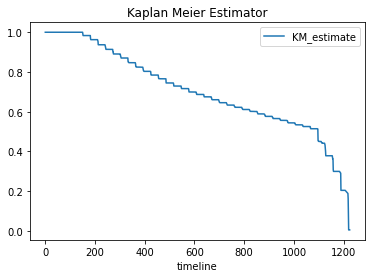

In [188]:
function.plot(title='Kaplan Meier Estimator')

In [189]:
model.median_survival_time_

1097.0

In [190]:
model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,5906,5906
1.0,2,0,2,0,5906
2.0,4,0,4,0,5904
3.0,3,0,3,0,5900
6.0,2,0,2,0,5897
...,...,...,...,...,...
1217.0,3,3,0,0,39
1218.0,5,5,0,0,36
1219.0,16,16,0,0,31


In [191]:
df_2006.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,51453366538336630763636,NaN,NaN,2006-08-22,Chargedoff,Not available,2008-05-22,Professional,NaN,True,5833.333333,Not displayed,10000,1,639
1,A3A23365984305581EF2551,NaN,NaN,2006-07-17,Completed,NaN,2009-10-22,NaN,NaN,False,9583.333333,Not displayed,10000,0,1193
2,CB203371350913895324563,NaN,NaN,2006-10-13,Completed,Not available,2007-04-13,Analyst,MO,True,7500.000000,Not displayed,6000,0,182
3,A7AC33650456321694DD117,NaN,NaN,2006-07-21,Completed,Not available,2007-08-10,Executive,MO,True,8583.333333,Not displayed,2200,0,385
4,D8C53374343326309856587,NaN,NaN,2006-11-14,Completed,Not available,2009-03-10,Clerical,NaN,True,1833.333333,Not displayed,5000,0,847


In [192]:
borrower = (df_2006['IsBorrowerHomeowner'] == True)

T = df_2006.time
E = df_2006.LoanStatus_Censored

model = KaplanMeierFitter()

model.fit(T[borrower], event_observed=E[borrower], label='Homeowner')
fig_1 = model.survival_function_

model.fit(T[~borrower], event_observed=E[~borrower], label='Not Homeowner')
fig_2 = model.survival_function_


figure = pd.concat([fig_1, fig_2], axis=1)
figure.plot(backend='plotly')

In [193]:
results = logrank_test(T[borrower], T[~borrower], event_observed_A=E[borrower],
                       event_observed_B=E[~borrower])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.36 <0.005     10.38

In [194]:
def survival(data, group_field, time_field, event_field):
  """
  Functions that receives a DF and filters by a column

  Returns 
    Survival function plot
    Logrank Test
  """

  model = KaplanMeierFitter()
  results = []
  con_exp = []

  for i in data[group_field].dropna().unique():
    group = data[data[group_field] == i]
    T = group[time_field]
    E = group[event_field]
    con_exp.append([T, E])
    model.fit(T, E, label=str(i))
    results.append(model.survival_function_)

  survival = pd.concat(results, axis=1)
  
  
  return survival


In [195]:
rates = survival(df_2006, 'Occupation', 'time', 'LoanStatus_Censored')
rates.plot(kind='line', title='Pago completo dependiendo de su ocupación', 
           backend='plotly')

### Cox Model

In [196]:
df_2006.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,51453366538336630763636,NaN,NaN,2006-08-22,Chargedoff,Not available,2008-05-22,Professional,NaN,True,5833.333333,Not displayed,10000,1,639
1,A3A23365984305581EF2551,NaN,NaN,2006-07-17,Completed,NaN,2009-10-22,NaN,NaN,False,9583.333333,Not displayed,10000,0,1193
2,CB203371350913895324563,NaN,NaN,2006-10-13,Completed,Not available,2007-04-13,Analyst,MO,True,7500.000000,Not displayed,6000,0,182
3,A7AC33650456321694DD117,NaN,NaN,2006-07-21,Completed,Not available,2007-08-10,Executive,MO,True,8583.333333,Not displayed,2200,0,385
4,D8C53374343326309856587,NaN,NaN,2006-11-14,Completed,Not available,2009-03-10,Clerical,NaN,True,1833.333333,Not displayed,5000,0,847


In [197]:
to_model = df_2006[['LoanOriginalAmount', 'IsBorrowerHomeowner', 'StatedMonthlyIncome', 
                    'time', 'LoanStatus_Censored']]

In [198]:
model = CoxPHFitter()
model.fit(to_model, duration_col='time', event_col='LoanStatus_Censored')

<lifelines.CoxPHFitter: fitted with 5906 total observations, 3581 right-censored observations>

In [199]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 5906 total observations, 3581 right-censored observations>
             duration col = 'time'
                event col = 'LoanStatus_Censored'
      baseline estimation = breslow
   number of observations = 5906
number of events observed = 2325
   partial log-likelihood = -18423.80
         time fit was run = 2021-10-27 16:49:05 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
LoanOriginalAmount   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IsBorrowerHomeowner  -0.06       0.94       0.05            -0.16             0.03                 0.85                 1.03
StatedMonthlyIncome  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                        z      p   -log2(p)
covariate                                  
LoanOriginalAmount  -0.22   0.82       0.28
IsBorrowerHomeowner -1.35   0.18       2.51
StatedMonthlyIncome -6.00 <0.005      28.91
---
Concordance = 0.58
Partial AIC = 36853.59
log-likelihood ratio test = 60.40 on 3 df
-log2(p) of ll-ratio test = 40.92

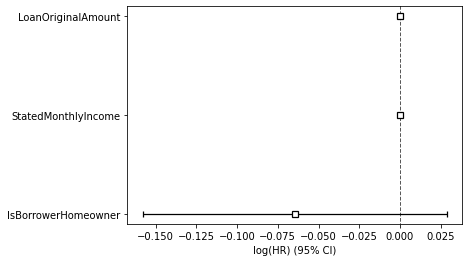

In [200]:
model.plot()

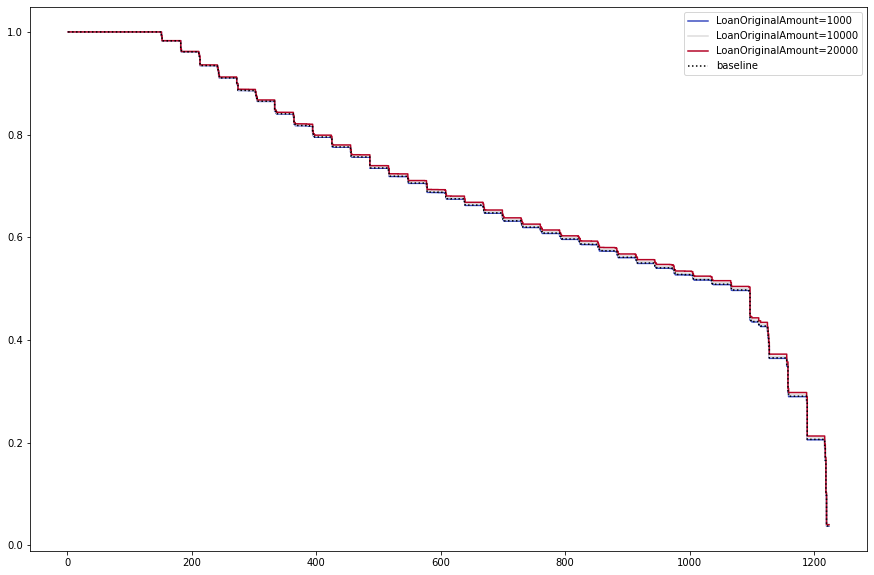

In [201]:
model.plot_partial_effects_on_outcome(covariates='LoanOriginalAmount',
                                      values=[1000, 10_000, 
                                              20_000], cmap='coolwarm',
                                      figsize=(15, 10))

### DF filter 2009


In [235]:
df_2009 = df_status_clean[df_status_clean['LoanOriginationDate'].dt.year == 2009].reset_index(drop=True)
df_2009.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,60B735657994093942AA7B2,6.0,94.0,2009-09-15,Completed,Full-time,2012-09-15,Professional,MD,True,15000.000000,"$100,000+",10000,0,1096
1,06A73569349574436F63BE2,6.0,20.0,2009-10-20,Completed,Full-time,2011-09-30,Accountant/CPA,MD,False,4833.333333,"$50,000-74,999",5000,0,710
2,79D13567170266105A6A095,7.0,259.0,2009-09-22,Completed,Full-time,2010-03-17,Professional,OK,False,4169.333333,"$50,000-74,999",2200,0,176
3,7A3C357134717718161464C,4.0,227.0,2009-11-04,Completed,Full-time,2012-01-13,Administrative Assistant,FL,False,4333.333333,"$50,000-74,999",1500,0,800
4,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669


In [236]:
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045 entries, 0 to 2044
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   LoanKey                   2045 non-null   object        
 1   ProsperRating (numeric)   1974 non-null   float64       
 2   EmploymentStatusDuration  2045 non-null   float64       
 3   LoanOriginationDate       2045 non-null   datetime64[ns]
 4   LoanStatus                2045 non-null   object        
 5   EmploymentStatus          2045 non-null   object        
 6   ClosedDate                2045 non-null   datetime64[ns]
 7   Occupation                2045 non-null   object        
 8   BorrowerState             2045 non-null   object        
 9   IsBorrowerHomeowner       2045 non-null   bool          
 10  StatedMonthlyIncome       2045 non-null   float64       
 11  IncomeRange               2045 non-null   object        
 12  LoanOriginalAmount  

In [237]:
dummies = pd.get_dummies(df_2009[['EmploymentStatus']], drop_first=True)
dummies.head()

,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [238]:
df_2009.IncomeRange.unique()

array(['$100,000+', '$50,000-74,999', '$25,000-49,999', '$75,000-99,999',
       '$1-24,999', '$0', 'Not employed'], dtype=object)

In [239]:
def income_range_ordinal(label: str):
  if label in ('$0', 'Not employed'):
    return 0
  elif label == '$1-24,999':
    return 1
  elif label == '$75,000-99,999':
    return 2
  elif label == '$25,000-49,999':
    return 3
  elif label == '$50,000-74,999':
    return 4
  else:
    return 5

In [240]:
df_2009['IncomeRange_ord'] = df_2009.IncomeRange.apply(income_range_ordinal)

In [241]:
df_2009.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord
0,60B735657994093942AA7B2,6.0,94.0,2009-09-15,Completed,Full-time,2012-09-15,Professional,MD,True,15000.000000,"$100,000+",10000,0,1096,5
1,06A73569349574436F63BE2,6.0,20.0,2009-10-20,Completed,Full-time,2011-09-30,Accountant/CPA,MD,False,4833.333333,"$50,000-74,999",5000,0,710,4
2,79D13567170266105A6A095,7.0,259.0,2009-09-22,Completed,Full-time,2010-03-17,Professional,OK,False,4169.333333,"$50,000-74,999",2200,0,176,4
3,7A3C357134717718161464C,4.0,227.0,2009-11-04,Completed,Full-time,2012-01-13,Administrative Assistant,FL,False,4333.333333,"$50,000-74,999",1500,0,800,4
4,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669,3


In [242]:
df_2009_dumm = pd.concat([df_2009, dummies], axis=1)
df_2009_dumm.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,60B735657994093942AA7B2,6.0,94.0,2009-09-15,Completed,Full-time,2012-09-15,Professional,MD,True,15000.000000,"$100,000+",10000,0,1096,5,0,0,0,0
1,06A73569349574436F63BE2,6.0,20.0,2009-10-20,Completed,Full-time,2011-09-30,Accountant/CPA,MD,False,4833.333333,"$50,000-74,999",5000,0,710,4,0,0,0,0
2,79D13567170266105A6A095,7.0,259.0,2009-09-22,Completed,Full-time,2010-03-17,Professional,OK,False,4169.333333,"$50,000-74,999",2200,0,176,4,0,0,0,0
3,7A3C357134717718161464C,4.0,227.0,2009-11-04,Completed,Full-time,2012-01-13,Administrative Assistant,FL,False,4333.333333,"$50,000-74,999",1500,0,800,4,0,0,0,0
4,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669,3,0,0,0,0


In [243]:
df_2009_num = df_2009_dumm._get_numeric_data()
df_2009_num.head()

,ProsperRating (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,StatedMonthlyIncome,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,6.0,94.0,True,15000.000000,10000,0,1096,5,0,0,0,0
1,6.0,20.0,False,4833.333333,5000,0,710,4,0,0,0,0
2,7.0,259.0,False,4169.333333,2200,0,176,4,0,0,0,0
3,4.0,227.0,False,4333.333333,1500,0,800,4,0,0,0,0
4,7.0,74.0,True,3000.000000,5000,1,669,3,0,0,0,0


In [244]:
null_col = df_2009_num.isnull().mean()
null_col[null_col > 0]

ProsperRating (numeric)    0.034719
dtype: float64

In [245]:
df_2009_num.dropna(inplace=True)

In [246]:
df_2009_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 0 to 2044
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ProsperRating (numeric)         1974 non-null   float64
 1   EmploymentStatusDuration        1974 non-null   float64
 2   IsBorrowerHomeowner             1974 non-null   bool   
 3   StatedMonthlyIncome             1974 non-null   float64
 4   LoanOriginalAmount              1974 non-null   int64  
 5   LoanStatus_Censored             1974 non-null   int64  
 6   time                            1974 non-null   int64  
 7   IncomeRange_ord                 1974 non-null   int64  
 8   EmploymentStatus_Not employed   1974 non-null   uint8  
 9   EmploymentStatus_Part-time      1974 non-null   uint8  
 10  EmploymentStatus_Retired        1974 non-null   uint8  
 11  EmploymentStatus_Self-employed  1974 non-null   uint8  
dtypes: bool(1), float64(3), int64(4), 

In [247]:
df_2009_num.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

### Cox Model 2009

In [248]:
to_model = df_2009_num.iloc[:, 0:10]

In [249]:
model = CoxPHFitter()
model.fit(df_2009_num, duration_col='time', event_col='LoanStatus_Censored')

model.print_summary()

<lifelines.CoxPHFitter: fitted with 1974 total observations, 1671 right-censored observations>
             duration col = 'time'
                event col = 'LoanStatus_Censored'
      baseline estimation = breslow
   number of observations = 1974
number of events observed = 303
   partial log-likelihood = -1989.53
         time fit was run = 2021-10-27 16:52:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
ProsperRating (numeric)         -0.22       0.80       0.03            -0.29            -0.16                 0.75                 0.86
EmploymentStatusDuration         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IsBorrowerHomeowner             -0.11       0.89       0.12            -0.36             0.13                 0.70                 1.14
StatedMonthlyIncome             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LoanOriginalAmount               0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
IncomeRange_ord                  0.04       1.04       0.06            -0.08             0.17                 0.92                 1.19
EmploymentStatus_Not employed   -0.58       0.56       0.73            -2.02             0.86                 0.13                 2.35
EmploymentStatus_Part-time       0.18       1.20       0.33            -0.47             0.83                 0.62                 2.30
EmploymentStatus_Retired         0.29       1.34       0.39            -0.46             1.05                 0.63                 2.87
EmploymentStatus_Self-employed  -0.18       0.83       0.31            -0.79             0.42                 0.45                 1.53

                                   z      p   -log2(p)
covariate                                             
ProsperRating (numeric)        -6.61 <0.005      34.63
EmploymentStatusDuration        1.22   0.22       2.18
IsBorrowerHomeowner            -0.89   0.37       1.42
StatedMonthlyIncome            -1.20   0.23       2.11
LoanOriginalAmount              2.38   0.02       5.86
IncomeRange_ord                 0.67   0.50       1.00
EmploymentStatus_Not employed  -0.80   0.43       1.23
EmploymentStatus_Part-time      0.54   0.59       0.76
EmploymentStatus_Retired        0.76   0.45       1.17
EmploymentStatus_Self-employed -0.59   0.55       0.85
---
Concordance = 0.65
Partial AIC = 3999.07
log-likelihood ratio test = 54.91 on 10 df
-log2(p) of ll-ratio test = 24.86

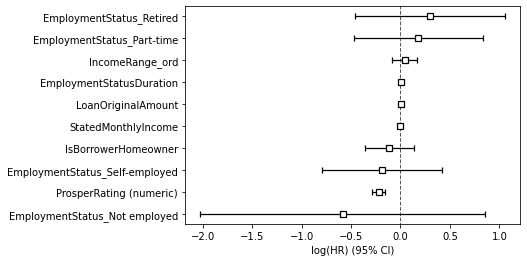

In [250]:
model.plot()

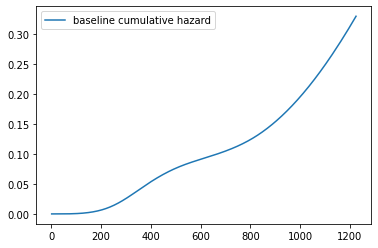

In [253]:
model = CoxPHFitter(baseline_estimation_method='spline', n_baseline_knots=4)
model.fit(df_2009_num, duration_col='time', event_col='LoanStatus_Censored')

# model.print_summary()
model.baseline_cumulative_hazard_.plot()